# Evaluation des performances de différents modèles

## Import lib et data

In [1]:
# Classique
import pandas as pd
import numpy as np
import re
import joblib
import time
import random
from collections import Counter

# Lime
from lime import lime_tabular

# Visu
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
pd.set_option('display.max_columns', None)

# utils
import utils

# MLFlow
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn

# SKlearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    StratifiedKFold, LearningCurveDisplay
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, \
                            precision_score, recall_score, make_scorer, \
                            average_precision_score, f1_score, fbeta_score, \
                            accuracy_score
from sklearn.linear_model import LogisticRegression

# ImbLearn (SMOTE)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline, Pipeline

# LightGBM
from lightgbm import LGBMClassifier

---

## Séparation des données

In [2]:
train_df = pd.read_csv('Data/train.csv')
feats = [f for f in train_df.columns if f not in 
         ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df[feats]
y = train_df['TARGET']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    train_size = 0.8,
                                                    random_state = 42)

In [4]:
print('Shape of training set')
print('X_train : {}'.format(X_train.shape))
print('y_train : {}'.format(y_train.shape))
print('ratio TARGET : ', y_train.value_counts(normalize=True).values)
print('------------------------')
print('Shape of test set')
print('X_test : {}'.format(X_test.shape))
print('y_test : {}'.format(y_test.shape))
print('ratio TARGET : ',y_test.value_counts(normalize=True).values)

Shape of training set
X_train : (245990, 120)
y_train : (245990,)
ratio TARGET :  [0.91927314 0.08072686]
------------------------
Shape of test set
X_test : (61498, 120)
y_test : (61498,)
ratio TARGET :  [0.91926567 0.08073433]


In [5]:
idx = random.randint(1, len(X_test))
data_test = X_train.iloc[[idx]]
data_test.to_csv('flask_application/data_test.csv')

## Pré-traitement des données

### Imputations et Scaling

In [6]:
num_features = make_column_selector(dtype_include = ['float64'])

pipe_num = Pipeline([
    ("impnum", SimpleImputer(strategy = 'median')),
    ("sc", StandardScaler()),
])

cat_features = make_column_selector(dtype_exclude = ['float64'])
pipe_cat = Pipeline([
    ("impcat", SimpleImputer(strategy = 'most_frequent'))
])

preprocessor = make_column_transformer((pipe_num, num_features),
                                       (pipe_cat, cat_features))


### Traitement désequilibre des classes

In [7]:
over_sampler = SMOTE(random_state=42)

under_sampler = RandomUnderSampler(random_state=42)

## Définition des scores utilisés pour évaluer nos modèles

In [8]:
scoring = {'AUC' : 'roc_auc',
           'AP_score' : make_scorer(average_precision_score,needs_proba=True),
           'f1_score' : 'f1',
           'f10_score' : make_scorer(fbeta_score, beta=10),
           'accuracy' : 'accuracy'
          }

# Logistic Regression

## Sélection hyperparamètres avec GridSearch

In [9]:
pipeline = Pipeline([
    ('imputer_scaler', preprocessor),
    ('over', over_sampler),
    ('under', under_sampler),
    ('estimator',  LogisticRegression(tol=0.1))
])

param_grid = {
    "estimator__C": [0.001, 0.002],
    "estimator__max_iter": [200, 300],
    "estimator__solver": ["newton-cholesky", 'lbfgs'],
    "over__sampling_strategy": [0.1, 0.2, 0.5]
}

cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit='f10_score') # changer refit par auc

In [10]:
print('Entrainement du modèle...')
start = time.time()
grid.fit(X_train, y_train)
end = time.time()
delta = round((end - start), 3)
print('Temps total CV : {}s'.format(delta))

Entrainement du modèle...
Temps total CV : 761.914s


## Evaluation du modèle

In [11]:
b_score = grid.best_score_
b_params = grid.best_params_
print('Résultat sur le jeu d\'entrainement avec cross-validation')
print('Meilleur score : {}'.format(b_score))
print('Meilleur params : {}'.format(b_params))

Résultat sur le jeu d'entrainement avec cross-validation
Meilleur score : 0.644805380885409
Meilleur params : {'estimator__C': 0.002, 'estimator__max_iter': 200, 'estimator__solver': 'lbfgs', 'over__sampling_strategy': 0.1}


In [12]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__max_iter,param_estimator__solver,param_over__sampling_strategy,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_AP_score,split1_test_AP_score,split2_test_AP_score,split3_test_AP_score,split4_test_AP_score,mean_test_AP_score,std_test_AP_score,rank_test_AP_score,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,split3_test_f1_score,split4_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_test_f10_score,split1_test_f10_score,split2_test_f10_score,split3_test_f10_score,split4_test_f10_score,mean_test_f10_score,std_test_f10_score,rank_test_f10_score,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,4.991858,0.270934,0.760108,0.072786,0.001,200,newton-cholesky,0.1,"{'estimator__C': 0.001, 'estimator__max_iter':...",0.747324,0.741732,0.741434,0.743231,0.746092,0.743963,0.002355,5,0.218799,0.219060,0.222769,0.224559,0.221762,0.221390,0.002201,21,0.260753,0.259234,0.255933,0.258684,0.260672,0.259055,0.001756,3,0.642238,0.638104,0.637318,0.641137,0.644398,0.640639,0.002623,21,0.697122,0.696695,0.691532,0.694195,0.695841,0.695077,0.002036,1
1,5.061239,0.364585,0.733358,0.042249,0.001,200,newton-cholesky,0.2,"{'estimator__C': 0.001, 'estimator__max_iter':...",0.746754,0.741944,0.740378,0.743483,0.745808,0.743673,0.002364,13,0.219286,0.221958,0.222855,0.226447,0.223004,0.222710,0.002296,5,0.260822,0.257275,0.256634,0.258694,0.261093,0.258904,0.001807,5,0.646894,0.634149,0.639958,0.643925,0.644681,0.641921,0.004486,13,0.694927,0.695455,0.691370,0.692813,0.696390,0.694191,0.001835,13
2,5.161883,0.273582,0.763970,0.064750,0.001,200,newton-cholesky,0.5,"{'estimator__C': 0.001, 'estimator__max_iter':...",0.744926,0.739472,0.737890,0.741991,0.743829,0.741621,0.002626,19,0.217660,0.221421,0.220313,0.226135,0.222771,0.221660,0.002798,13,0.260371,0.257205,0.256812,0.257505,0.262261,0.258831,0.002127,9,0.644051,0.634605,0.639747,0.637974,0.646681,0.640612,0.004300,23,0.695597,0.695110,0.691776,0.693829,0.697305,0.694723,0.001847,5
3,5.333127,0.435662,0.841983,0.093903,0.001,200,lbfgs,0.1,"{'estimator__C': 0.001, 'estimator__max_iter':...",0.747166,0.741593,0.741402,0.743074,0.745892,0.743825,0.002317,7,0.218078,0.218756,0.222282,0.223623,0.220331,0.220614,0.002088,23,0.260215,0.258611,0.256705,0.258279,0.259935,0.258749,0.001263,15,0.645659,0.641050,0.643679,0.645498,0.646863,0.644550,0.002024,3,0.694540,0.694195,0.689601,0.691329,0.693402,0.692614,0.001874,21
4,5.446112,0.233136,0.774076,0.059210,0.001,200,lbfgs,0.2,"{'estimator__C': 0.001, 'estimator__max_iter':...",0.746892,0.741907,0.740532,0.743604,0.745728,0.743733,0.002347,9,0.218554,0.221960,0.223158,0.225974,0.222674,0.222464,0.002383,7,0.260707,0.257206,0.256570,0.258027,0.260018,0.258506,0.001600,23,0.648274,0.635535,0.642270,0.644539,0.645016,0.643127,0.004252,7,0.694053,0.694642,0.690089,0.691390,0.694459,0.692927,0.001842,17
5,7.004701,0.322101,0.729204,0.015578,0.001,200,lbfgs,0.5,"{'estimator__C': 0.001, 'estimator__max_iter':...",0.744936,0.739467,0.738079,0.742214,0.743716,0.741682,0.002565,17,0.217567,0.221438,0.220925,0.226084,0.222744,0.221752,0.002758,11,0.260204,0.257266,0.256913,0.258303,0.261770,0.258891,0.001839,7,0.643334,0.634845,0.639760,0.640162,0.645228,0.640666,0.003546,19,0.695679,0.695089,0.691939,0.694053,0.697223,0.694797,0.001759,3
6,4.903523,0.234206,0.790343,0.065469,0.001,300,newton-cholesky,0.1,"{'estimator__C': 0.001, 'estimator__max_iter':...",0.747324,0.741732,0.741434,0.743231,0.746092,0.743963,0.002355,5,0.218799,0.219060,0.222769,0.224559,0.221762,0.221390,0.002201,21,0.260753,0.259234,0.255933,0.258684,0.260672,0.259055,0.001756,3,0.642238,0.638104,0.637318,0.641137,0.644398,0.640639,0.002623,21,0.697122,0.696695,0.6915

Résultat sur le jeu de test avec le meilleur modèle retenu


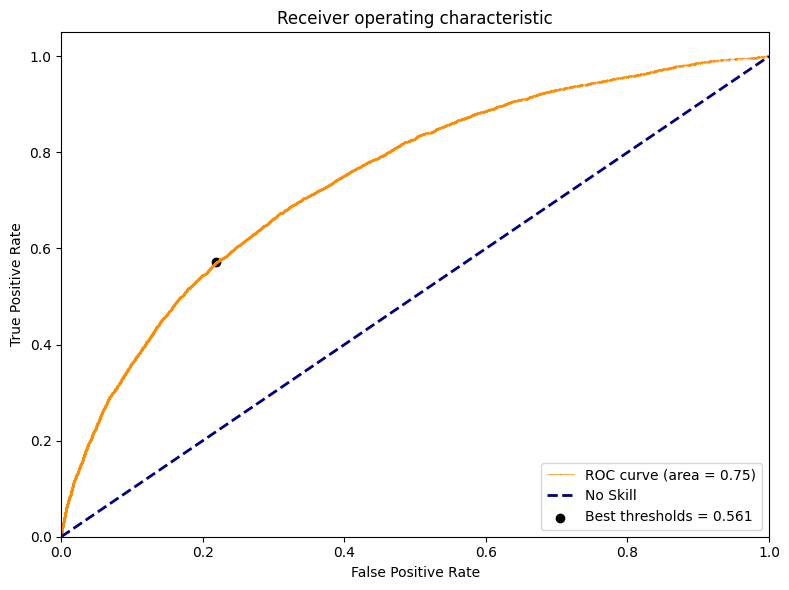

Fbeta score (beta=10), seuil=0.5 : 0.647182948765062
Fbeta score (beta=10), seuil=0.561 : 0.5597820563932991


In [13]:
predictions = grid.predict_proba(X_test)[:, 1]
preds = grid.predict(X_test)

print('Résultat sur le jeu de test avec le meilleur modèle retenu')
best_thresh = utils.plot_roc_auc(y_test, predictions)

preds_threshed = (grid.predict_proba(X_test)[:, 1] > best_thresh).astype(int)

print('Fbeta score (beta=10), seuil=0.5 : {}'.format(
    fbeta_score(y_test, preds, beta=10)))
print('Fbeta score (beta=10), seuil={} : {}'.format(
    round(best_thresh, 3), fbeta_score(y_test, preds_threshed, beta=10)))

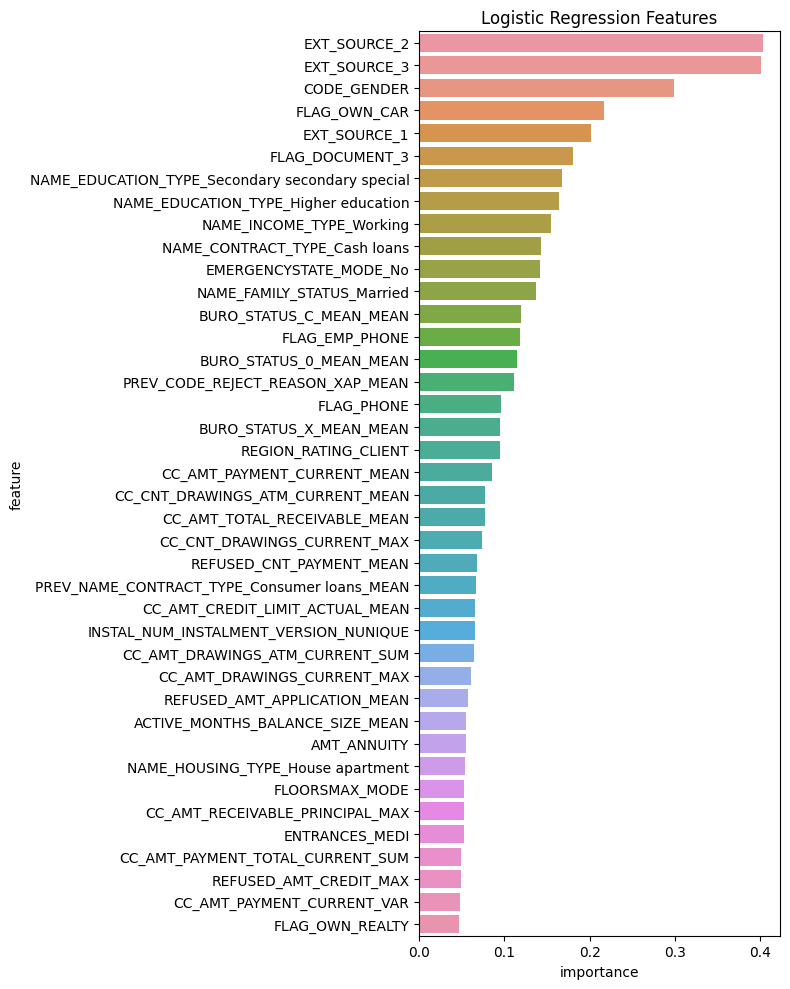

In [14]:
importance_df = pd.DataFrame()

names = grid.best_estimator_.named_steps['imputer_scaler'].get_feature_names_out()
feature_names = []
for name in names:
    name1 = name.replace('pipeline-1__', '')
    name2 = name1.replace('pipeline-2__', '')
    feature_names.append(name2)

importance_df["feature"] = feature_names
importance_df["importance"] = np.abs(grid.best_estimator_['estimator'].coef_[0])

title = 'Logistic Regression Features'
utils.display_importances(importance_df, title)

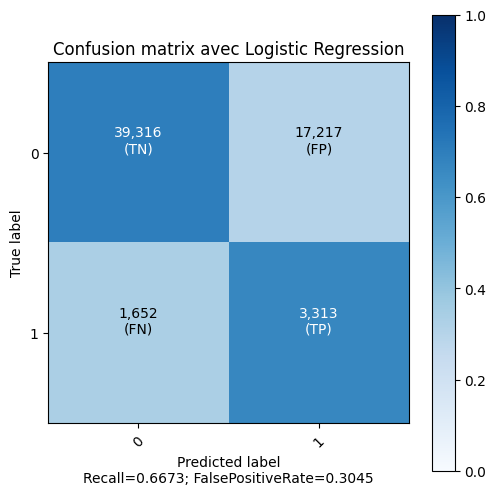

In [15]:
cm = confusion_matrix(y_test, preds)
title = 'Confusion matrix avec Logistic Regression'
utils.plot_confusion_matrix(cm, ['0', '1'], title, normalize=True)

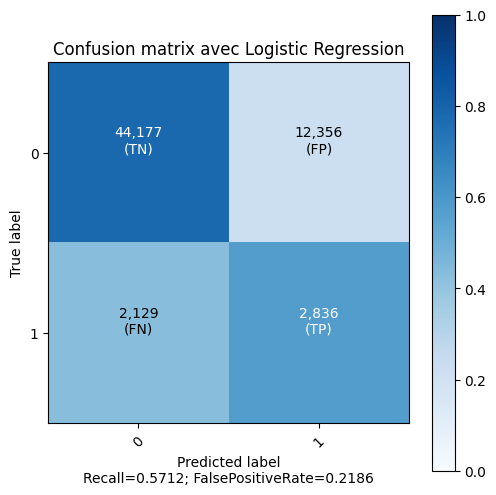

In [16]:
cm = confusion_matrix(y_test, preds_threshed)
title = 'Confusion matrix avec Logistic Regression'
utils.plot_confusion_matrix(cm, ['0', '1'], title, normalize=True)

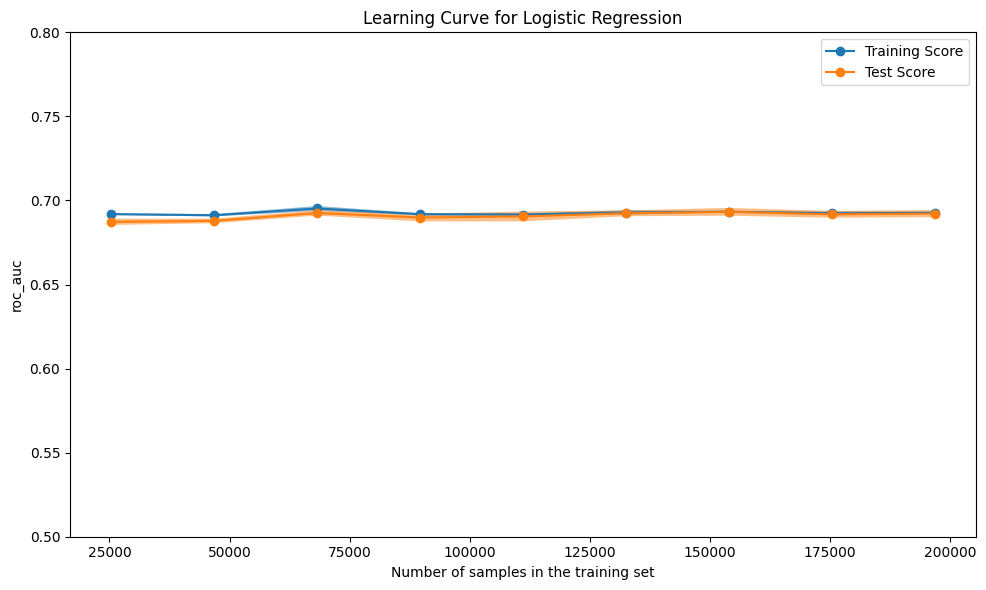

In [17]:
utils.plot_learning_curve(X_train, y_train, grid.best_estimator_)

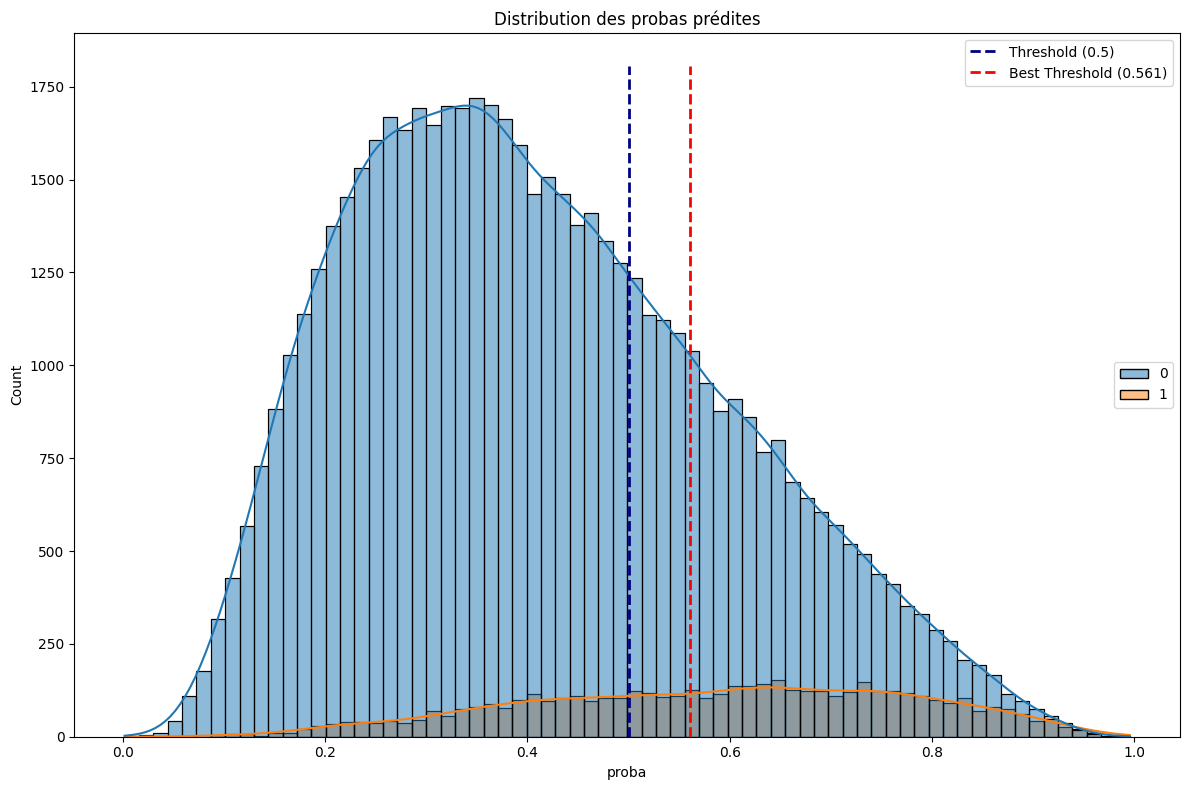

In [18]:
utils.plot_hist_proba(predictions, y_test, best_thresh)

## Enregistrement params/metrics/artefacts avec MLFlow

In [19]:
# avant cela nous allons reconstruire le dataset pour savoir le train et le test
def artifact_df(X_training, y_training, X_test, y_test, feats):
    df_train = pd.DataFrame(X_training, columns=feats)
    df_train['target'] = y_training
    df_train.to_csv('train_data.csv')

    df_test = pd.DataFrame(X_test, columns=feats)
    df_test['target'] = y_test
    df_test.to_csv('test_data.csv')

    return None

In [20]:
# Création d'une fonction personnalisée pour effectuer des prédictions en fonction d'un seuil
class CustomModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model, threshold=0.5):
        self.model = model
        self.threshold = threshold

    def predict(self, context, model_input):
        # Prédiction personnalisée avec le paramètre threshold
        probabilities = self.model.predict_proba(model_input)
        predictions = (probabilities[:, 1] >= self.threshold).astype(int)
        return predictions
    
    def predict_proba(self, context, model_input):
        return self.model.predict_proba(model_input)

C:\Users\julie\anaconda3\lib\site-packages\mlflow\models\signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
C:\Users\julie\anaconda3\lib\site-packages\mlflow\models\signature.py:153: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data con

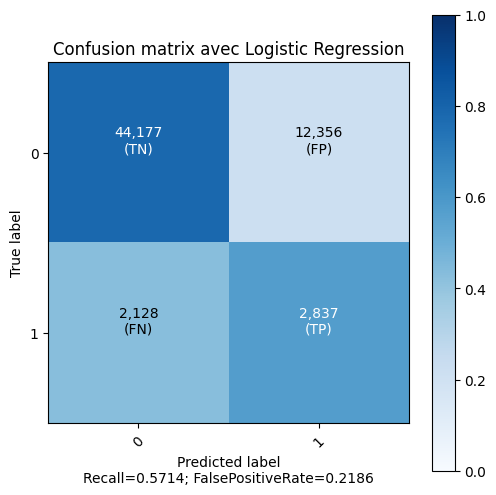

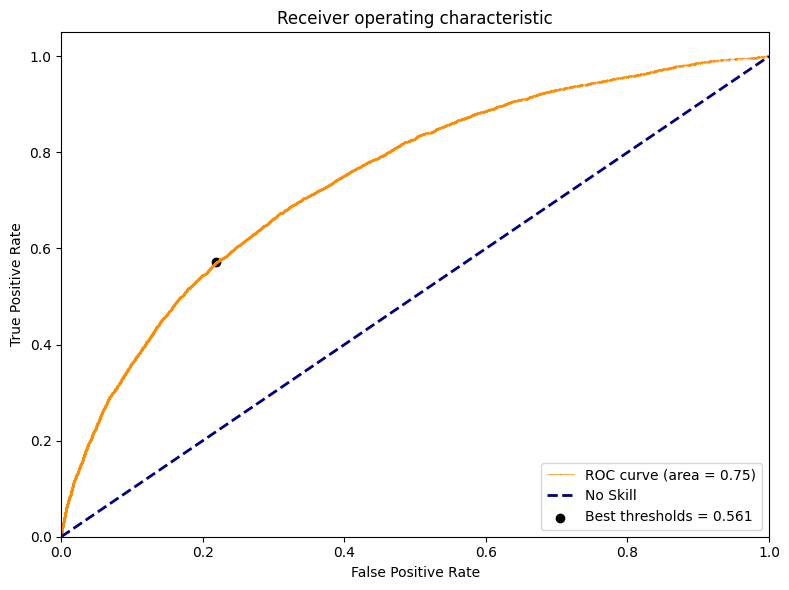

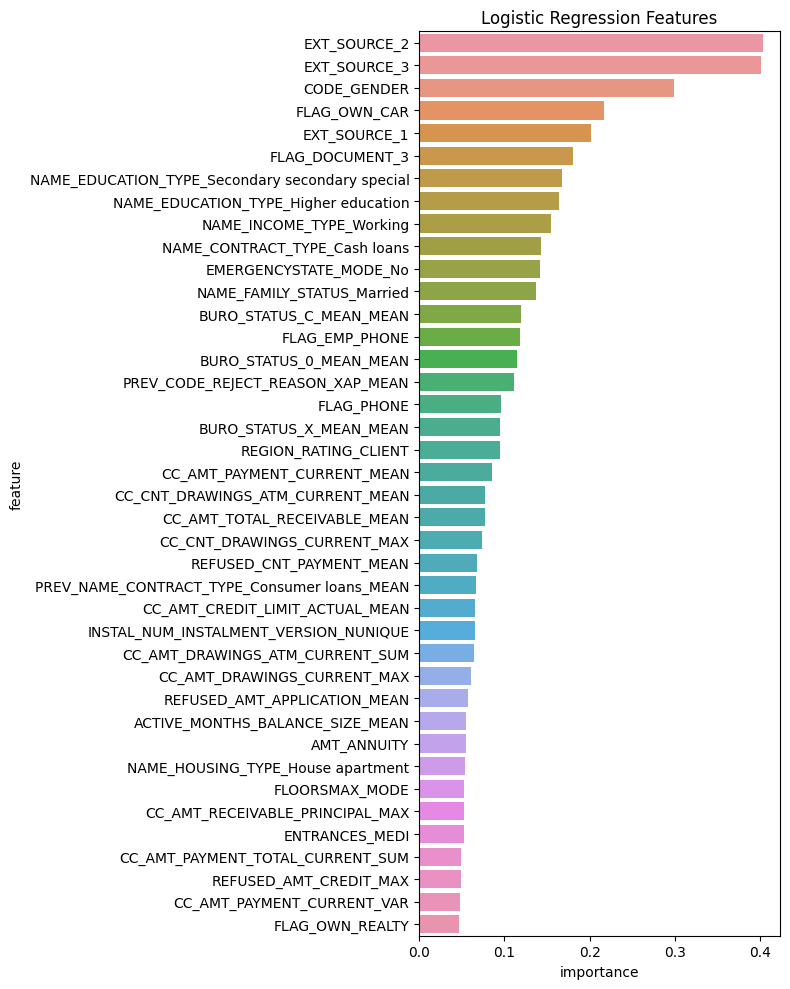

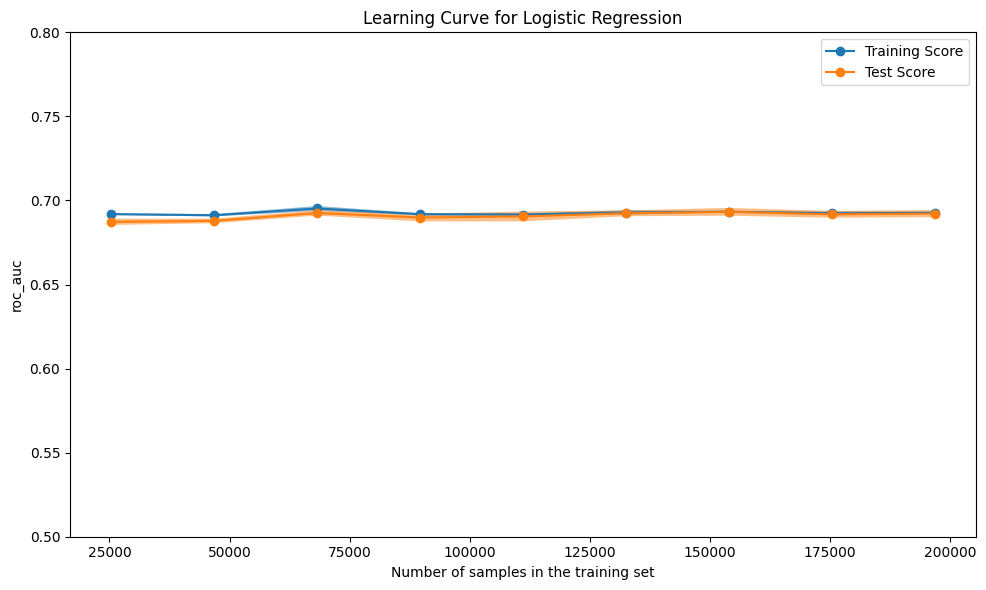

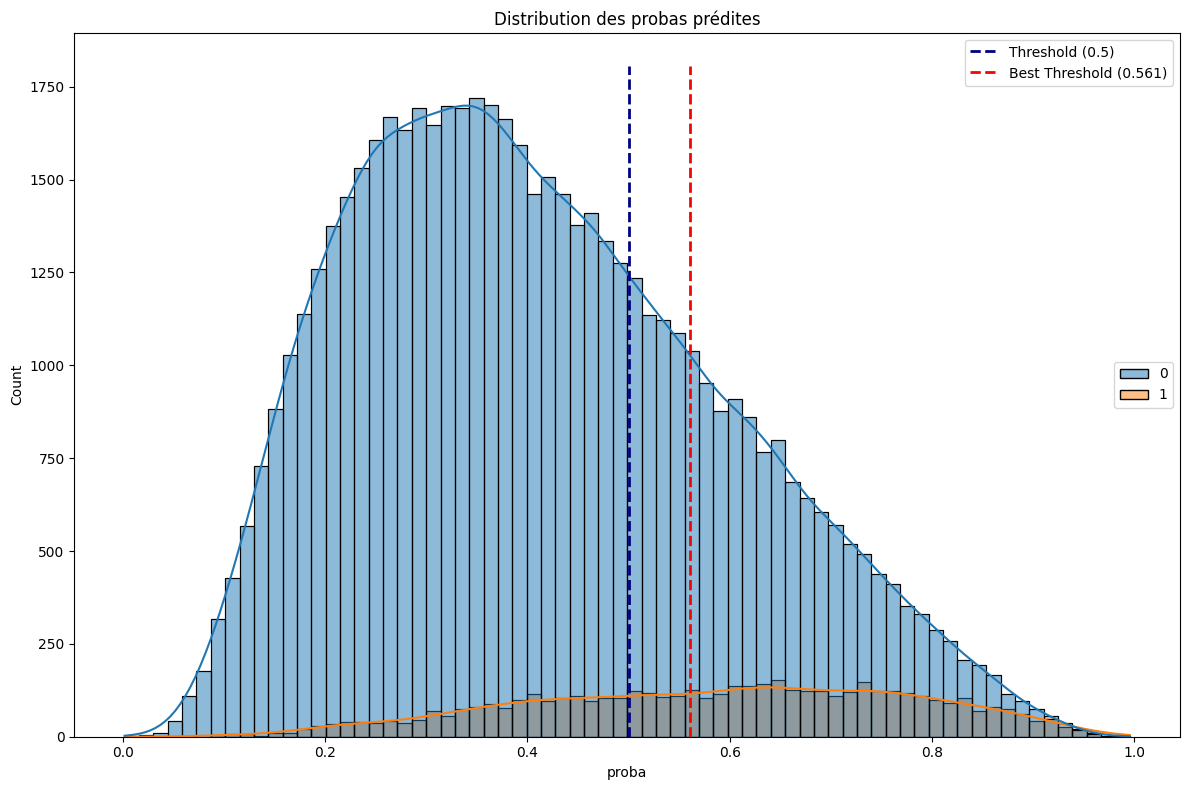

In [48]:
run_description = """
### Data
Dataset complet
Sélection de feature : condition sur la variance
                       Kbest (k=200) basé sur mutual_info_classif
                       corrélation entre variables
Imputation simple : float --> median
                    int   --> most frequent
Standard scaler pour vars continues
Over and under sampling pour gérer déséquilibre de classe

### Modèle
logistic regression paramétrer avec GridSearchCV
Threshold adapté au problème (cout FN = 10 * cout FP)
"""
run_name = 'LogisticRegression_Smote'

with mlflow.start_run(run_name=run_name, description=run_description):

    # Enregistrement de plusieurs paramètres sous forme d'un dictionnaire
    params = {}
    params['MODEL_NAME'] = 'LogisticRegression'
    params['PARAMS_CV'] = b_params
    params['THRESHOLD'] = best_thresh
    params['BETA'] = 10
    params['TRAIN_SIZE'] = len(X_train)
    params['TEST_SIZE'] = len(X_test)
    params['SEED'] = 42
    mlflow.log_params(params)

    # On note le moment du début de l'expérience pour mesurer la durée de l'entraînement
    start = time.time()

    # Initialisation du modèle
    params = dict(**b_params)
    pred_pipeline = Pipeline([
        ('imputer_scaler', preprocessor),
        ('over', over_sampler),
        ('under', under_sampler),
        ('estimator',  LogisticRegression(tol=0.1))
    ])
    pred_pipeline.set_params(**params)
    signature = infer_signature(X_train, y_train)

    # Entraînement du modèle
    pred_pipeline.fit(X_train, y_train)

    training_time = time.time() - start

    # # Enregistrement du modèle
    
    # Appliquons le seuil de prédiction souhaité avec fonction personnalisée
    custom_threshold = best_thresh
    custom_model = CustomModelWrapper(pred_pipeline, threshold=custom_threshold)
    
    predictions = custom_model.predict(None, X_test)
    predictions_proba = pred_pipeline.predict_proba(X_test)[:, 1]

    # Enregistrez le modèle avec le seuil ajusté dans MLflow
    mlflow.pyfunc.log_model(
    python_model=custom_model,  
    artifact_path="mlflow_LR_with_threshold",  
    signature=signature
    )
    
    # Enregistrement du modèle avec joblib
    joblib.dump(pred_pipeline, 'flask_application/model.joblib')

    # Enregistrement de plusieurs métriques sous forme d'un dictionnaire
    metrics = {}
    metrics['Auc'] = roc_auc_score(y_test, predictions_proba)
    metrics['Fbeta'] = fbeta_score(y_test, predictions, beta=10)
    metrics['Precision'] = precision_score(y_test, predictions)
    metrics['Recall'] = recall_score(y_test, predictions)
    metrics['Accuracy'] = accuracy_score(y_test, predictions)
    metrics['Training Time'] = training_time
    mlflow.log_metrics(metrics)

    # Enregistrement de la matrice de confusion
    cm = confusion_matrix(y_test, predictions)
    title = 'Confusion matrix avec Logistic Regression'
    utils.plot_confusion_matrix(cm, ['0', '1'], title)
    mlflow.log_artifact('Data/matrix.png')

    # Enregistrement courbe ROC
    utils.plot_roc_auc(y_test, predictions_proba)
    mlflow.log_artifact('Data/roc_auc_curve.png')

    # Enregistrement features importance du modèle
    importance_df = pd.DataFrame()
    importance_df["feature"] = feature_names
    importance_df["importance"] = np.abs(pred_pipeline['estimator'].coef_[0])

    title = 'Logistic Regression Features'
    utils.display_importances(importance_df, title)
    mlflow.log_artifact('Data/features_importances.png')

    # Enregistrement Learning curve
    utils.plot_learning_curve(X_train, y_train, pred_pipeline)
    mlflow.log_artifact('Data/learning_curve.png')
    
    # Enregistrement disribution probas
    utils.plot_hist_proba(predictions_proba, y_test, best_thresh)
    mlflow.log_artifact('Data/distribution_pred_probas.png')
    
    # # Enregistrement des datasets train et test
    # artifact_df(X_train, y_train, X_test, y_test, feats)
    # mlflow.log_artifact('train_data.csv')
    # mlflow.log_artifact('test_data.csv')
      

## Feature importance with LIME

In [40]:
nb_num_feats = len(X.select_dtypes(include='float64').columns)
nb_total_feats = X.shape[1]
cat_features = list(range(nb_num_feats, nb_total_feats))
class_names = ['accordé', 'refusé']

X_smpl = X.sample(10000)
X_smpl_tr = grid.best_estimator_.named_steps['imputer_scaler'].transform(X_smpl)

lime_data = pd.DataFrame(X_smpl_tr, columns=feature_names)
lime_data.to_csv('flask_application/lime_data.csv', index=False)

explainer = lime_tabular.LimeTabularExplainer(X_smpl_tr, mode="classification",
                                              class_names=class_names,
                                              feature_names=feature_names,
                                              categorical_features=cat_features)

In [41]:
idx = random.randint(1, len(X_test))

X_test_tr = grid.best_estimator_.named_steps['imputer_scaler'].transform(X_test.iloc[[idx]])
predict_fn = grid.best_estimator_.named_steps['estimator'].predict_proba

pred = (grid.predict_proba(X_test.iloc[[idx]])[0][1] > best_thresh).astype(int)
print("Prediction : ", class_names[pred])
print("True :     ", class_names[int(y_test.iloc[idx])])

explanation = explainer.explain_instance(X_test_tr[0], predict_fn,
                                         num_features=15)

explanation.show_in_notebook()

Prediction :  accordé
True :      accordé


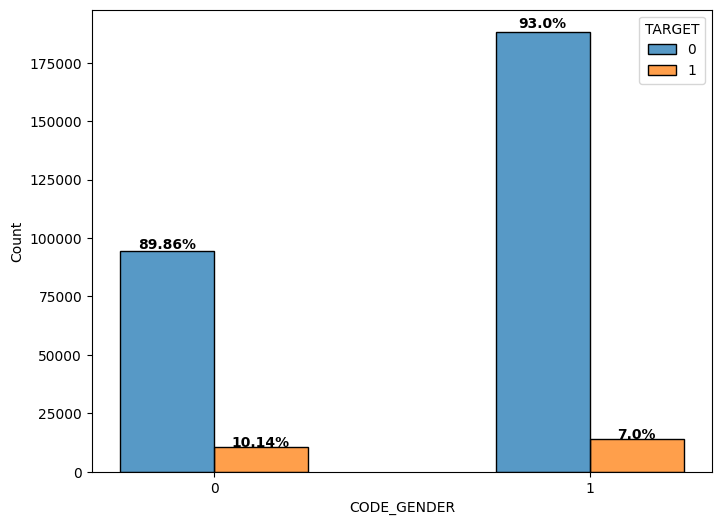

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))

data = train_df[['CODE_GENDER', 'TARGET']]
sns.histplot(data=data, ax=ax, x='CODE_GENDER', hue='TARGET', multiple='dodge', discrete=True, shrink=0.5)
ax.set_xticks([0, 1])

a = [p.get_height() for p in ax.patches]
pourcentage = [a[0]/(a[0] + a[2]), a[1]/(a[1] + a[3]), a[2]/(a[0] + a[2]), a[3]/(a[1] + a[3])]
pourcentage = [np.round(100*i, 2) for i in pourcentage]

for i, p in enumerate(ax.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
     
    plt.text(x+width/2,
             y+height*1.01,
             str(pourcentage[i])+'%',
             ha='center',
             weight='bold')
    
# pouvoir choisir quelle variable plot, et sur quel jeu de donnée (tout ou un cluster lié au client)

<AxesSubplot: xlabel='EXT_SOURCE_3', ylabel='Count'>

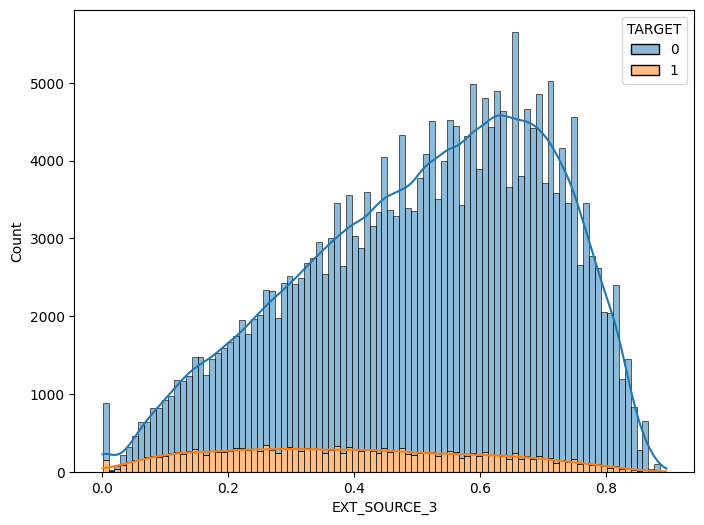

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))

data = train_df[['EXT_SOURCE_3', 'TARGET']]
sns.histplot(data=data, ax=ax, x='EXT_SOURCE_3', hue='TARGET', multiple='stack', kde=True)
#ax.set_xlim(0, 100)

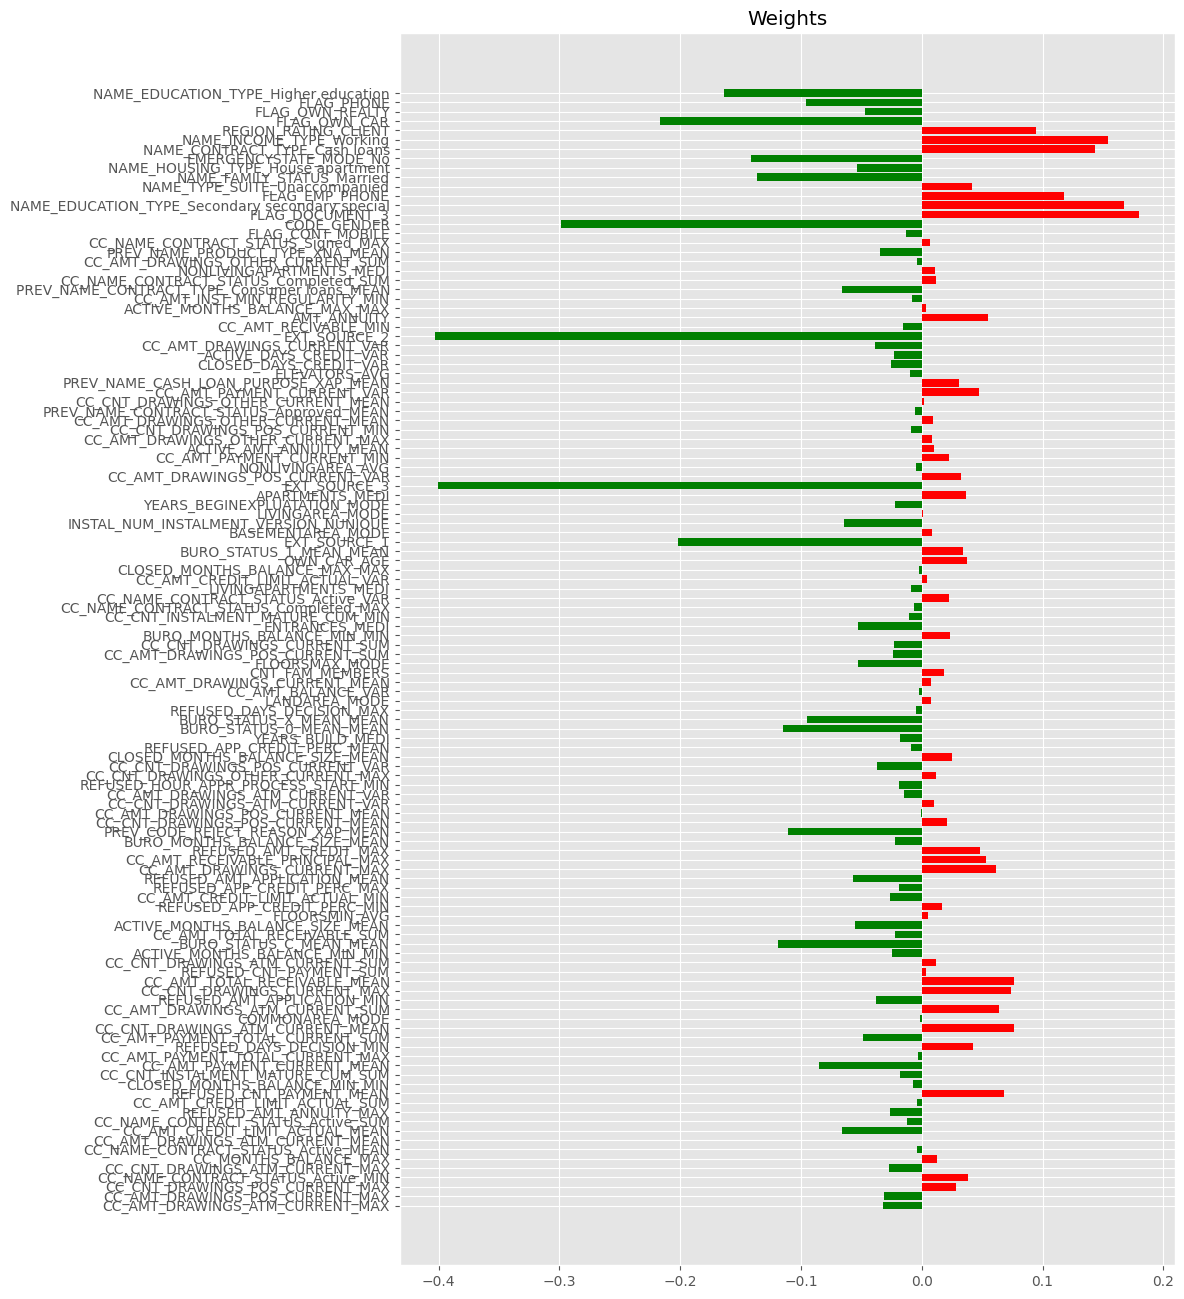

In [47]:
coefs = grid.best_estimator_['estimator'].coef_[0]
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(10,16))
    plt.barh(range(len(coefs)), coefs, color=["red" if coef>0 else "green" for coef in coefs])
    plt.yticks(range(len(coefs)), feature_names);
    plt.title("Weights")

# Light Gradient Boosting Model (LGBM)

## Sélection hyperparamètres avec GridSearch

In [51]:
def custom_scorer(y_true, y_proba):
    th = 0.085
    y_pred = (y_proba > th).astype(int)
    return 'f10', fbeta_score(y_true, y_pred, beta=10), True

In [52]:
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train,
                                      stratify=y_train,
                                      train_size = 0.8,
                                      random_state = 42)

In [53]:
param_grid = {
    'n_estimators': [5000],
    'learning_rate': [0.02],
    'scale_pos_weight': [1, 5, 10]
}

param_fit = {
    'early_stopping_rounds': 200,
    'eval_metric': 'auc',
    'eval_set' : [(X_v, y_v)],
    'verbose': 100
}
    

clf = LGBMClassifier(
    max_depth=8,
    num_leaves=31,
    colsample_bytree=0.85,
    subsample=0.8715623,
    subsample_freq=5,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.05,
    min_child_weight=39.3259775
)

cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, scoring=scoring, refit='AUC')

In [54]:
print('Entrainement du modèle...')
start = time.time()
grid.fit(X_t, y_t, **param_fit)
end = time.time()
delta = round((end - start), 3)
print('Temps total CV : {}s'.format(delta))

Entrainement du modèle...


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.745034	valid_0's binary_logloss: 0.25183
[200]	valid_0's auc: 0.752609	valid_0's binary_logloss: 0.248167
[300]	valid_0's auc: 0.75495	valid_0's binary_logloss: 0.247238
[400]	valid_0's auc: 0.755935	valid_0's binary_logloss: 0.246843
[500]	valid_0's auc: 0.756252	valid_0's binary_logloss: 0.246714
[600]	valid_0's auc: 0.756361	valid_0's binary_logloss: 0.246644
[700]	valid_0's auc: 0.75606	valid_0's binary_logloss: 0.246687


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.746057	valid_0's binary_logloss: 0.251589
[200]	valid_0's auc: 0.753664	valid_0's binary_logloss: 0.24798
[300]	valid_0's auc: 0.75626	valid_0's binary_logloss: 0.246966
[400]	valid_0's auc: 0.757103	valid_0's binary_logloss: 0.246619
[500]	valid_0's auc: 0.757813	valid_0's binary_logloss: 0.24639
[600]	valid_0's auc: 0.758026	valid_0's binary_logloss: 0.246269
[700]	valid_0's auc: 0.75815	valid_0's binary_logloss: 0.24624
[800]	valid_0's auc: 0.758171	valid_0's binary_logloss: 0.246242


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.745437	valid_0's binary_logloss: 0.251677
[200]	valid_0's auc: 0.752489	valid_0's binary_logloss: 0.248204
[300]	valid_0's auc: 0.755338	valid_0's binary_logloss: 0.247162
[400]	valid_0's auc: 0.756484	valid_0's binary_logloss: 0.246811
[500]	valid_0's auc: 0.756923	valid_0's binary_logloss: 0.246658
[600]	valid_0's auc: 0.756848	valid_0's binary_logloss: 0.246607
[700]	valid_0's auc: 0.756643	valid_0's binary_logloss: 0.246625


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.744614	valid_0's binary_logloss: 0.251743
[200]	valid_0's auc: 0.752527	valid_0's binary_logloss: 0.248127
[300]	valid_0's auc: 0.755037	valid_0's binary_logloss: 0.247143
[400]	valid_0's auc: 0.756118	valid_0's binary_logloss: 0.24673
[500]	valid_0's auc: 0.756729	valid_0's binary_logloss: 0.24651
[600]	valid_0's auc: 0.757003	valid_0's binary_logloss: 0.246377
[700]	valid_0's auc: 0.756809	valid_0's binary_logloss: 0.246404


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.744783	valid_0's binary_logloss: 0.251614
[200]	valid_0's auc: 0.753146	valid_0's binary_logloss: 0.247933
[300]	valid_0's auc: 0.755669	valid_0's binary_logloss: 0.246945
[400]	valid_0's auc: 0.757274	valid_0's binary_logloss: 0.246442
[500]	valid_0's auc: 0.75753	valid_0's binary_logloss: 0.246329
[600]	valid_0's auc: 0.757688	valid_0's binary_logloss: 0.246212
[700]	valid_0's auc: 0.757792	valid_0's binary_logloss: 0.246156
[800]	valid_0's auc: 0.757585	valid_0's binary_logloss: 0.246205
[900]	valid_0's auc: 0.757162	valid_0's binary_logloss: 0.246309


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.749443	valid_0's binary_logloss: 0.348085
[200]	valid_0's auc: 0.754384	valid_0's binary_logloss: 0.366168


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.749635	valid_0's binary_logloss: 0.347462
[200]	valid_0's auc: 0.754421	valid_0's binary_logloss: 0.365168


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.749764	valid_0's binary_logloss: 0.347506
[200]	valid_0's auc: 0.754663	valid_0's binary_logloss: 0.365405


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.748913	valid_0's binary_logloss: 0.347924
[200]	valid_0's auc: 0.7542	valid_0's binary_logloss: 0.365766


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.750368	valid_0's binary_logloss: 0.346868
[200]	valid_0's auc: 0.755387	valid_0's binary_logloss: 0.364655


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.748292	valid_0's binary_logloss: 0.478119
[200]	valid_0's auc: 0.753465	valid_0's binary_logloss: 0.524263


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.749113	valid_0's binary_logloss: 0.476962
[200]	valid_0's auc: 0.754046	valid_0's binary_logloss: 0.522264


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.748675	valid_0's binary_logloss: 0.477276
[200]	valid_0's auc: 0.753463	valid_0's binary_logloss: 0.523278


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.748537	valid_0's binary_logloss: 0.477355
[200]	valid_0's auc: 0.753938	valid_0's binary_logloss: 0.52299


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.749941	valid_0's binary_logloss: 0.47606
[200]	valid_0's auc: 0.755059	valid_0's binary_logloss: 0.521716


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.74489	valid_0's binary_logloss: 0.251801
[200]	valid_0's auc: 0.752705	valid_0's binary_logloss: 0.248108
[300]	valid_0's auc: 0.755424	valid_0's binary_logloss: 0.247062
[400]	valid_0's auc: 0.756688	valid_0's binary_logloss: 0.246612
[500]	valid_0's auc: 0.756895	valid_0's binary_logloss: 0.246543
[600]	valid_0's auc: 0.757251	valid_0's binary_logloss: 0.246414
[700]	valid_0's auc: 0.757286	valid_0's binary_logloss: 0.246379
[800]	valid_0's auc: 0.757172	valid_0's binary_logloss: 0.246398
Temps total CV : 200.154s


## Evaluation du modèle

In [55]:
b_score = grid.best_score_
b_params = grid.best_params_
print('Résultat sur le jeu d\'entrainement avec cross-validation')
print('Meilleur score : {}'.format(b_score))
print('Meilleur params : {}'.format(b_params))

Résultat sur le jeu d'entrainement avec cross-validation
Meilleur score : 0.7539689074939779
Meilleur params : {'learning_rate': 0.02, 'n_estimators': 5000, 'scale_pos_weight': 1}


In [56]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,param_scale_pos_weight,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_AP_score,split1_test_AP_score,split2_test_AP_score,split3_test_AP_score,split4_test_AP_score,mean_test_AP_score,std_test_AP_score,rank_test_AP_score,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,split3_test_f1_score,split4_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_test_f10_score,split1_test_f10_score,split2_test_f10_score,split3_test_f10_score,split4_test_f10_score,mean_test_f10_score,std_test_f10_score,rank_test_f10_score,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,20.479241,1.632348,0.979498,0.184803,0.02,5000,1,"{'learning_rate': 0.02, 'n_estimators': 5000, ...",0.762196,0.755313,0.754593,0.750876,0.746867,0.753969,0.005097,1,0.244962,0.241129,0.234258,0.236653,0.229012,0.237203,0.005508,1,0.035152,0.043004,0.028178,0.038066,0.039275,0.036735,0.004965,1,0.018432,0.022556,0.01462,0.02002,0.020656,0.019257,0.002668,1,0.919104,0.919713,0.919381,0.919102,0.919203,0.919301,0.00023,1
1,6.725754,0.333826,0.237772,0.013053,0.02,5000,5,"{'learning_rate': 0.02, 'n_estimators': 5000, ...",0.731734,0.727665,0.727497,0.721733,0.720618,0.725849,0.004122,2,0.204319,0.203960,0.194388,0.202139,0.198898,0.200741,0.003712,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,2,0.919281,0.919256,0.919279,0.919279,0.919279,0.919275,0.00001,2
2,6.669820,0.469424,0.227908,0.012872,0.02,5000,10,"{'learning_rate': 0.02, 'n_estimators': 5000, ...",0.729036,0.723837,0.720635,0.718285,0.717322,0.721823,0.004249,3,0.193919,0.191721,0.182594,0.193097,0.183325,0.188931,0.004931,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,2,0.919281,0.919256,0.919279,0.919279,0.919279,0.919275,0.00001,2


Résultat sur le jeu de test avec le meilleur modèle retenu


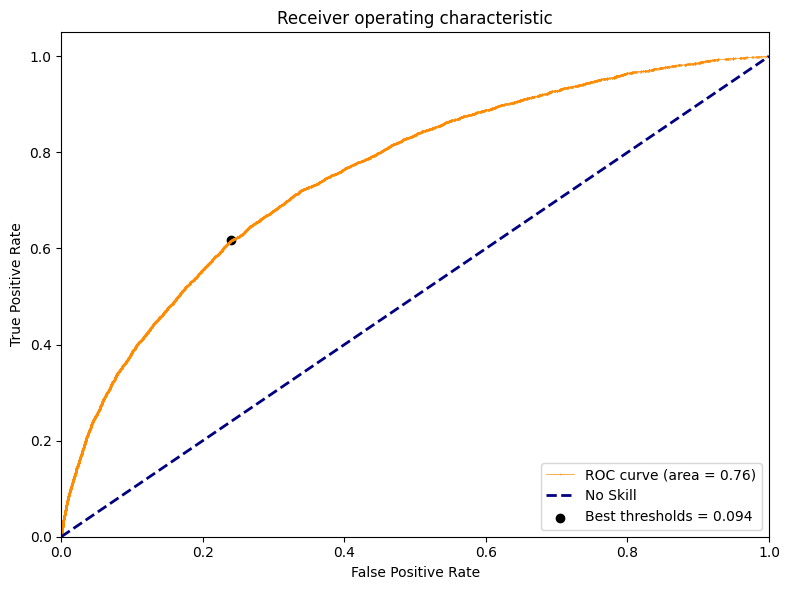

In [57]:
predictions = grid.predict_proba(X_test)[:, 1]

print('Résultat sur le jeu de test avec le meilleur modèle retenu')
best_thresh = utils.plot_roc_auc(y_test, predictions)

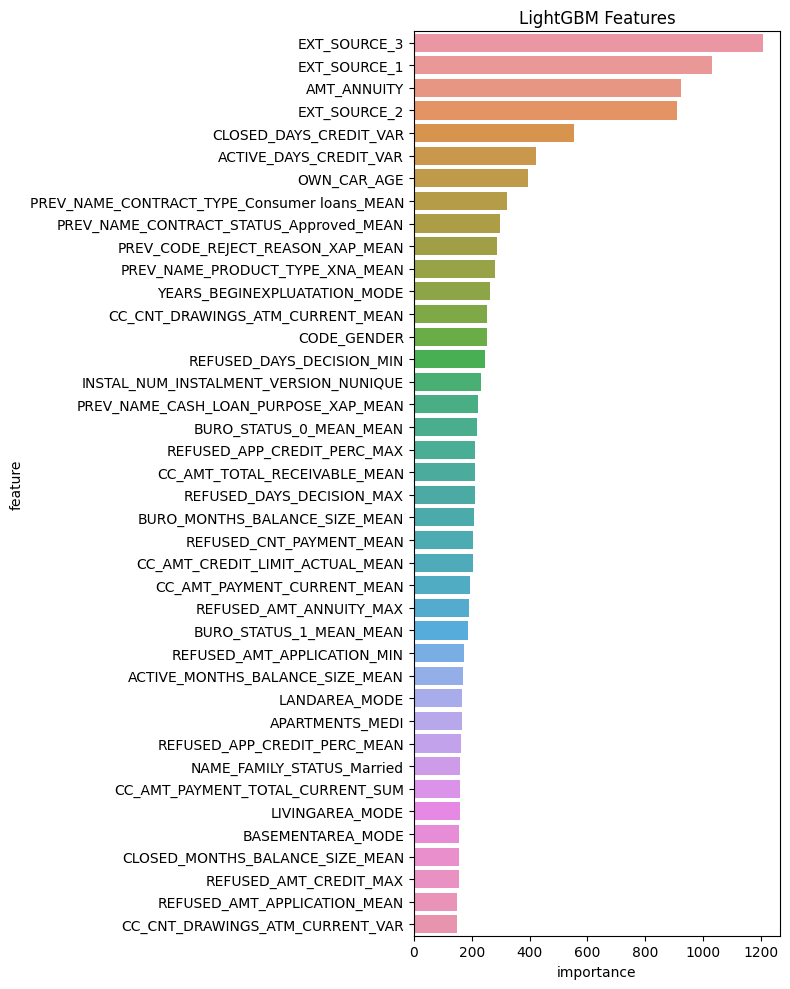

In [58]:
importance_df = pd.DataFrame()
importance_df["feature"] = feats
importance_df["importance"] = np.abs(grid.best_estimator_.feature_importances_)

title = 'LightGBM Features'
utils.display_importances(importance_df, title)

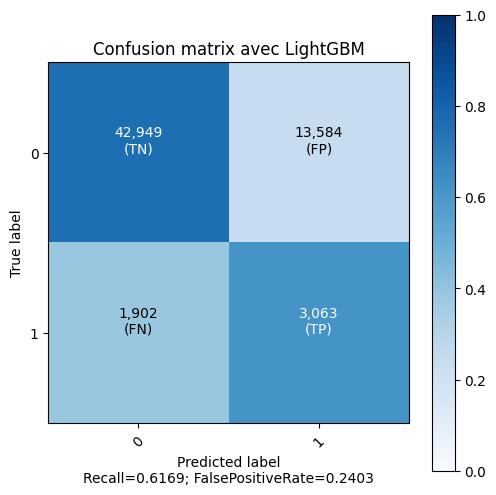

In [59]:
pred_threshed = []
for y in grid.predict_proba(X_test)[:, 1]:
    p = 0
    if y > best_thresh :
        p = 1
    pred_threshed.append(p)

cm = confusion_matrix(y_test, pred_threshed)
title = 'Confusion matrix avec LightGBM'
utils.plot_confusion_matrix(cm, ['0', '1'], title, normalize=True)

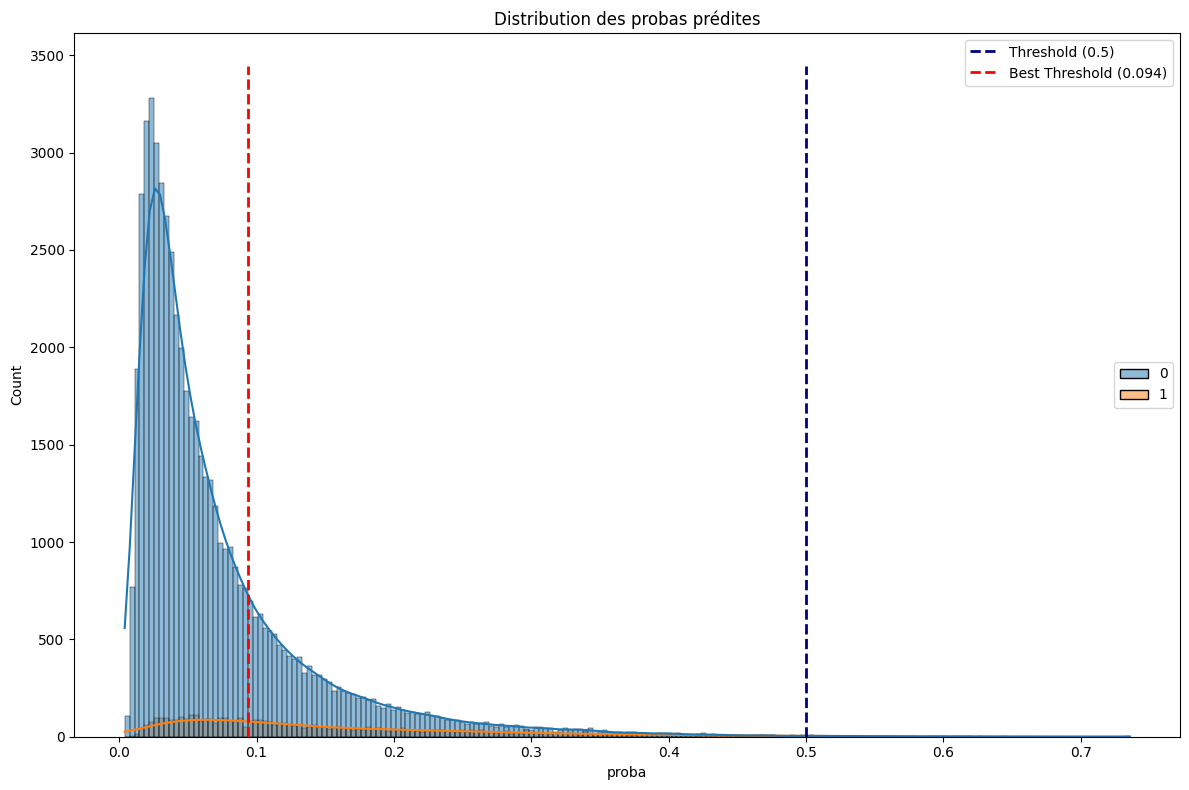

In [60]:
utils.plot_hist_proba(predictions, y_test, best_thresh)